# External Static B and ESR spectra

The electron-spin resonance spectrum in the context of ODMR contrasts is
modeled for a single $\text{NV}^-$ center and four NV centers along each orientation in a 
homogenous static magnetic field. 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qutip

In [3]:
import nvmodels
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
# matplotlib widget requires jupyter-lab and ipympl
# turns matplotlib figures interactive and zoomable

In [6]:
# %matplotlib widget

In [28]:
nv = nvmodels.NVNegativeGroundState(include_nuclear_states=False)

In [29]:
polar = 0
azimuthal = 0
_x = np.sin(polar)*np.cos(azimuthal)
_y = np.sin(polar)*np.sin(azimuthal)
_z = np.cos(polar)
B_mag = 100e-4  # 100 Gauss in the z direction
static_B_field = B_mag*np.array([_x, _y, _z])
print(static_B_field)

h = nv.zero_field_hamiltonian()
h += nv.nitrogen_hyperfine_hamiltonian()
h += nv.nitrogen_electric_quadrupole_hamiltonian()
h += nv.static_mag_field_hamiltonian(static_B_field, include_nucleus = True)

[0.   0.   0.01]


In [30]:
h

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 1.23698346e+09  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.91333333e+09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  6.76349873e+08]]

Text(0.5, 0, 'State index')

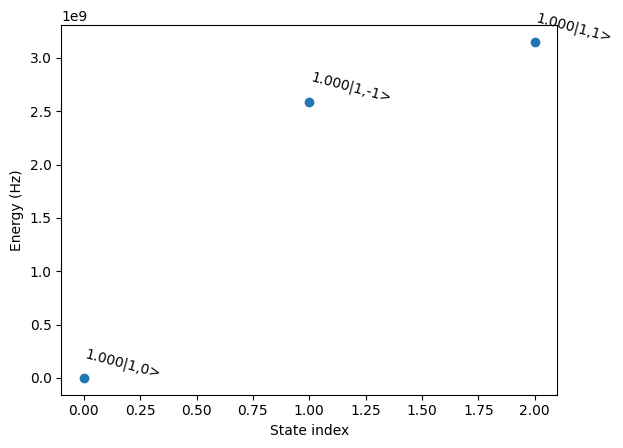

In [31]:
eigenvalues, eigenstates = h.eigenstates()
eigenvalues = eigenvalues - np.min(eigenvalues)
state_probs_text = [nvmodels.utilities.two_qutrit_state_to_text(s, decimals=5) for s in eigenstates]

fig, ax = nvmodels.plotting.plot_eigenspectrum_mpl(eigenvalues, state_probs_text)
ax.set_ylabel('Energy (Hz)')
ax.set_xlabel('State index')

In [35]:
state_probs_text = [nvmodels.utilities.two_qutrit_state_to_text(s, decimals=5) for s in eigenstates]
nvmodels.plotting.plot_eigenspectrum_plotly(eigenvalues, state_probs_text, ylabel = "Energy (Hz)")

In [37]:
rf_freq = np.arange(2.0e9, 3.5e9, 1e6)

In [44]:
energy_transitions = nv.electron_spin_resonances(h)
contrast = 1 + np.array([nvmodels.utilities.lorentzian(rf_freq, e, -0.01, 10e6) for e in energy_transitions]).sum(axis=0)

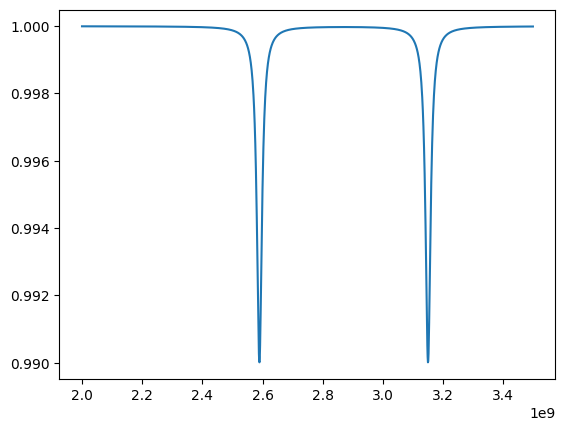

In [46]:
fix,ax = plt.subplots()

plt.plot(rf_freq, contrast)

## All 4 orientations

For ensembles of NV centers, we will have NV centers oriented in four different ways, according to the crystal structure of diamond. 
We want to add the other three NV center orientations but use the same B field that is was applied to our NV center above.
We need to find the rotation to the other three NV center axis

In [49]:
z = np.array([0,0,1])
nv111 = np.array([1,1,1])/np.linalg.norm(np.array([1,1,1]))
nv1b1b1 = np.array([1,-1,-1])/np.linalg.norm(np.array([1,-1,-1]))
nvb11b1 = np.array([-1, 1, -1])/np.linalg.norm(np.array([-1,1,-1]))
nvb1b11 = np.array([-1, -1, 1])/np.linalg.norm(np.array([-1,-1,1]))

nv_orientations = [nv111, nv1b1b1, nvb11b1, nvb1b11]

In [50]:
B_nv111_axis_in_lab_frame = 100e-4*np.array([1,1,1])/np.linalg.norm(np.array([1,1,1]))

In [51]:
# Demonstrate our rotation matrices
nvmodels.utilities.rotation_matrix_from_vectors(nv111,z)

array([[ 0.78867513, -0.21132487, -0.57735027],
       [-0.21132487,  0.78867513, -0.57735027],
       [ 0.57735027,  0.57735027,  0.57735027]])

In [52]:
nvmodels.utilities.lab_to_nv_orientation(z, nv111)# a z-vector in the lab frame represened in the nv111 frame

array([-0.57735027, -0.57735027,  0.57735027])

In [53]:
nvmodels.utilities.lab_to_nv_orientation(nv111, nv111)

array([-5.55111512e-17, -5.55111512e-17,  1.00000000e+00])

In [54]:
nvmodels.utilities.lab_to_nv_orientation(B_nv111_axis_in_lab_frame, nv111) # rotate to nv111 axis -- B should be entirely along Z

array([-4.33680869e-19, -4.33680869e-19,  1.00000000e-02])

In [55]:
nvmodels.utilities.lab_to_nv_orientation(B_nv111_axis_in_lab_frame, nvb1b11) #  rotate to nvb1b11 axis

array([ 0.00666667,  0.00666667, -0.00333333])

### B field aligned along 111

Using the B field aligned along 111, what should our ODMR spectrum look like?

In [70]:
energy_transitions = []
contrasts = []
rf_freq = np.arange(2.5e9, 3.3e9, 1e6)
lorentz_width = 10e6
contrast_amp = -0.01

for nv_orient in nv_orientations:
    h = nv.zero_field_hamiltonian()
    h += nv.nitrogen_hyperfine_hamiltonian()
    h += nv.nitrogen_electric_quadrupole_hamiltonian()

    B = nvmodels.utilities.lab_to_nv_orientation(B_nv111_axis_in_lab_frame, nv_orient)

    h += nv.static_mag_field_hamiltonian(B, include_nucleus = True)
    energy_transitions += nv.electron_spin_resonances(h)
    contrasts.append(np.array([nvmodels.utilities.lorentzian(rf_freq, e, contrast_amp, lorentz_width) for e in energy_transitions]).sum(axis=0))
    
full_spectrum = 1 + np.array(contrasts).sum(axis=0)

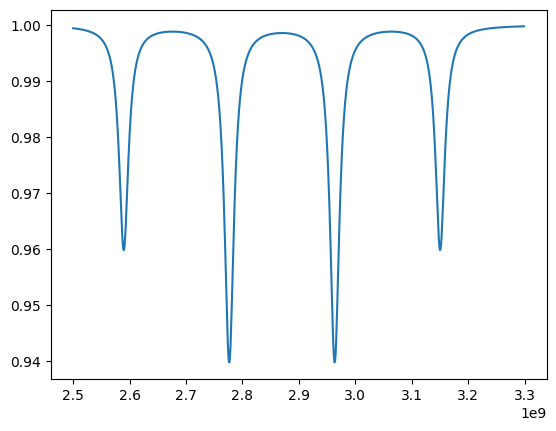

In [71]:
fix,ax = plt.subplots()
plt.plot(rf_freq, full_spectrum)

### Arbitrary B field direction.

Through trial and error, found a B field that ensures we see all splittings

In [74]:
energy_transitions = []
contrasts = []
# high res
rf_freq = np.arange(2.6e9, 3.15e9, .025e6)
lorentz_width = .5e6
contrast_amp = -0.01

# #low res
# rf_freq = np.arange(2.5e9, 3.3e9, 1e6)
# lorentz_width = 5e6
# contrast_amp = -0.01

v = np.array([.2,-.5,1]) #choose the direction of the B field

B_in_lab_frame = 100e-4*v/np.linalg.norm(v)

for nv_orient in nv_orientations:
    h = nv.zero_field_hamiltonian()
    h += nv.nitrogen_hyperfine_hamiltonian()
    h += nv.nitrogen_electric_quadrupole_hamiltonian()

    B = nvmodels.utilities.lab_to_nv_orientation(B_in_lab_frame, nv_orient)

    h += nv.static_mag_field_hamiltonian(B, include_nucleus = True)
    energy_transitions += nv.electron_spin_resonances(h)
    contrasts.append(np.array([nvmodels.utilities.lorentzian(rf_freq, e, contrast_amp, lorentz_width) for e in energy_transitions]).sum(axis=0))
    
full_spectrum = 1 + np.array(contrasts).sum(axis=0)

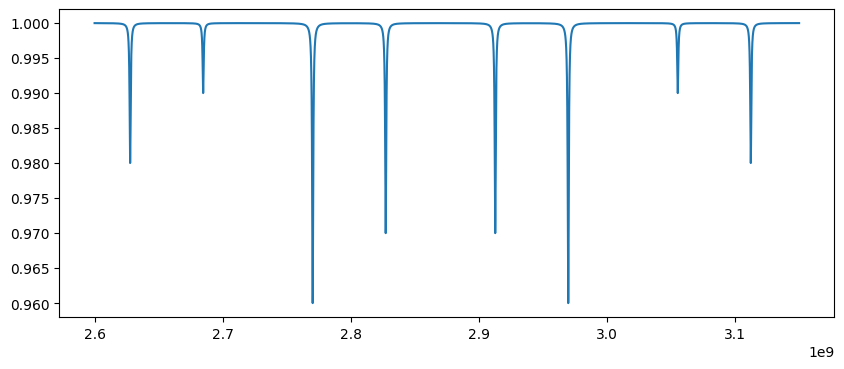

In [75]:
fix,ax = plt.subplots(figsize=(10,4))
plt.plot(rf_freq, full_spectrum)